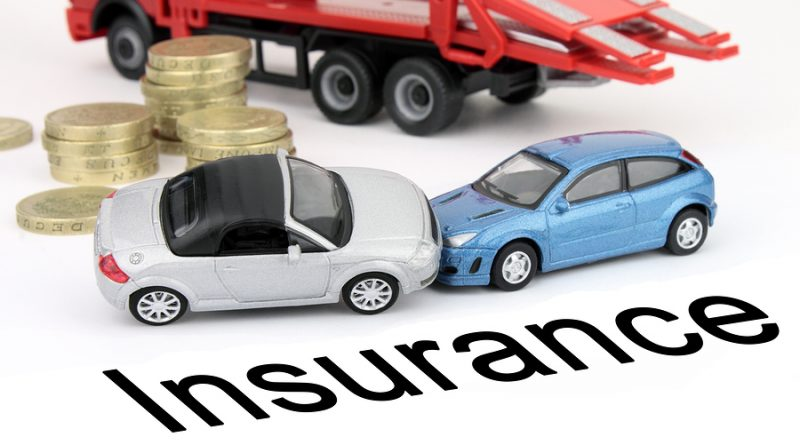

# **Problem Overview**

An insurance company that has provided Health Insurance to its customers now wants to offer Vehicle insurance also. We are required to develop a model that helps predict whether the policyholders (customers) from past year will also be interested in purchasing Vehicle Insurance provided by the company.

The following data is given for building the model:
* id - Unique cust id
* Gender
* Cust age
* Has Driving License - Yes or No
* Region Code
* Previously insured - Yes or No
* Vehicle Age
* Vehicle Damage - Yes or No
* Annual Premium
* Policy Sales Channel
* Vintage - Days of association between company and customer

Target variable:
* Response - Intersted or Not interested

Building a model to predict whether a customer would be interested in Vehicle Insurance is extremely helpful for the company because it can then accordingly plan its communication strategy to reach out to those customers and optimise its business model and revenue.

**In this Notebook, I will**
* Perform EDA
* Do some data cleaning
* Prepare features for feeding to the model
* Evaluate 3 classification algorithms with default parameters first
* Perform Hyperparameter tuning using RandomizedSearchCV
* Generate predictions using the best model
* Make submission

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, confusion_matrix, auc, f1_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/health-insurance-cross-sell-prediction/train.csv')
test = pd.read_csv('../input/health-insurance-cross-sell-prediction/test.csv')
sample = pd.read_csv('../input/health-insurance-cross-sell-prediction/sample_submission.csv')

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
sample.head()

In [ ]:
print(train.info())
print('*'*50)
print(test.info())

**Exploratory Data Analysis**

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(train['Annual_Premium'], bins=50)
plt.title('Annual Premium Distribution')
plt.subplot(1,2,2)
sns.distplot(np.log1p(train['Annual_Premium']), bins=50)
plt.title('Log  Distribution of Annual Premium')

In [ ]:
train['Annual_Premium'].sort_values().tail(10)

Most customers are paying annual premium less than Rs.100000. However there are some paying as high as Rs.500000 and above

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(train['Vintage'], bins = 50, color='indigo')
plt.title('Distribution of Vintage (Days of association between company and customers)')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(train['Age'], bins=50, color='green')
plt.title('Customer Age distribution')

In [ ]:
fig = px.pie(train, names='Gender', title='Gender distribution', color = 'Gender', color_discrete_map={'Male':'darkgreen','Female':'yellow'})
fig.show()

In [ ]:
fig = px.pie(train, names='Driving_License', title='Driving License distribution')
fig.show()

Almost all customers have Driving License. This is not a very useful feature to learn from. 

In [ ]:
fig = px.pie(train, names='Previously_Insured', title='Previously Insured distribution')
fig.show()

Interesting to see that even though 99.8% has DL, only 45.8% has Vehicle insurance. 

In [ ]:
fig = px.pie(train, names='Vehicle_Damage', title='Vehicle Damage distribution')
fig.show()

Half the customers have had a damage to their vehicle in the past. The case for vehicle insurance is strong!

In [ ]:
fig = px.pie(train, names='Vehicle_Age', title='Vehicle Age distribution')
fig.show()

In [ ]:
fig = px.pie(train, names='Region_Code', title='Region Code distribution')
fig.show()

Significant population of customers are from Region Code 28 (~28%). Approx. 50% of total customers are from only 5 regions.

In [ ]:
train.head()

In [ ]:
plt.figure(figsize=(8,8))
corr = train.drop(['Region_Code', 'Policy_Sales_Channel'], axis=1).corr()
sns.heatmap(corr)

**Data Cleaning**

In [ ]:
columns = ['Gender', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']
for col in columns:
    print(train[col].value_counts(), '\n')

In [ ]:
# One hot encode Gender
train = (train.merge(pd.get_dummies(train.Gender), left_index=True, right_index=True)).drop(['Gender'], axis=1)
test = (test.merge(pd.get_dummies(test.Gender), left_index=True, right_index=True)).drop(['Gender'], axis=1)

# One hot encode Vehicle Age
train = (train.merge(pd.get_dummies(train.Vehicle_Age), left_index=True, right_index=True)).drop(['Vehicle_Age'], axis=1)
test = (test.merge(pd.get_dummies(test.Vehicle_Age), left_index=True, right_index=True)).drop(['Vehicle_Age'], axis=1)

# One hot encode Vehicle Damage
train = (train.merge(pd.get_dummies(train.Vehicle_Damage, prefix = 'veh_damage'),  left_index=True, right_index=True)).drop(['Vehicle_Damage'], axis=1)
test = (test.merge(pd.get_dummies(test.Vehicle_Damage,  prefix = 'veh_damage'), left_index=True, right_index=True)).drop(['Vehicle_Damage'], axis=1)

In [ ]:
train.head()

In [ ]:
test.head()

In [ ]:
print(train.shape, test.shape)

In [ ]:
train['Policy_Sales_Channel'] = pd.Categorical(train['Policy_Sales_Channel'].astype(int))
test['Policy_Sales_Channel'] = pd.Categorical(test['Policy_Sales_Channel'].astype(int))
train['Region_Code'] = pd.Categorical(train['Region_Code'].astype(int))
test['Region_Code'] = pd.Categorical(test['Region_Code'].astype(int))

In [ ]:
# One hot encode Region Code
train = (train.merge(pd.get_dummies(train.Region_Code, prefix = 'reg_code'),  \
                     left_index=True, right_index=True)).drop(['Region_Code'], axis=1)
test = (test.merge(pd.get_dummies(test.Region_Code,  prefix = 'reg_code'), \
                   left_index=True, right_index=True)).drop(['Region_Code'], axis=1)

print(train.info())
print('='*50)
print(test.info())

In [ ]:
print(train.shape, test.shape)

In [ ]:
train.head()

# Split training data into train / valid / test sets

In [ ]:
np.random.seed(14321)

X_train, X_valid, X_test = np.split(train.sample(frac=1), [int(.7*len(train)), int(.85*len(train))])

print(f' Data shape: \n X_train shape: {X_train.shape} \n X_valid shape: {X_valid.shape} \n X_test shape: {X_test.shape}')

In [ ]:
y_train = X_train['Response']
X_train.drop(['id','Response'], axis=1, inplace=True)
y_valid = X_valid['Response']
X_valid.drop(['id','Response'], axis=1, inplace=True)
y_test = X_test['Response']
X_test.drop(['id','Response'], axis=1, inplace=True)

In [ ]:
print(f' X_train shape: {X_train.shape} \n y_train shape: {y_train.shape}')

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# LightGBM Classifier

In [ ]:
lgb = LGBMClassifier()
lgb.fit(X_train, y_train)
pred_y_train = lgb.predict_proba(X_train)[:, 1]
pred_y_valid = lgb.predict_proba(X_valid)[:, 1]
print(f'Train score: {roc_auc_score(y_train, pred_y_train):.4f}')
print(f'Val score: {roc_auc_score(y_valid, pred_y_valid):.4f}')

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, pred_y_valid)
plt.figure(figsize=(8,5))
sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
plt.plot(fpr, tpr)
plt.plot((0,1), ls = 'dashed', color = 'red', label='ROC Curve (AUC: %.4f)' % auc(fpr, tpr))
plt.title('LGBMClassifier ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(max_depth = 30, min_samples_split = 100, min_samples_leaf = 50)
rfc.fit(X_train, y_train)
pred_y_train = rfc.predict_proba(X_train)[:, 1]
pred_y_valid = rfc.predict_proba(X_valid)[:, 1]
print(f'Train score: {roc_auc_score(y_train, pred_y_train):.4f}')
print(f'Val score: {roc_auc_score(y_valid, pred_y_valid):.4f}')

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, pred_y_valid)
plt.figure(figsize=(8,5))
sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
plt.plot(fpr, tpr)
plt.plot((0,1), ls = 'dashed', color = 'red', label='ROC Curve (AUC: %.4f)' % auc(fpr, tpr))
plt.title('RandomForestClassifier ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Cat Boost Classifier

In [ ]:
cbc = CatBoostClassifier(iterations=200, learning_rate=0.1, eval_metric = 'AUC', verbose=0)
cbc.fit(X_train, y_train)
pred_y_train = cbc.predict_proba(X_train)[:, 1]
pred_y_valid = cbc.predict_proba(X_valid)[:, 1]
print(f'Train score: {roc_auc_score(y_train, pred_y_train):.4f}')
print(f'Val score: {roc_auc_score(y_valid, pred_y_valid):.4f}')

In [ ]:
fpr, tpr, _ = roc_curve(y_valid, pred_y_valid)
plt.figure(figsize=(8,5))
sns.set('talk', 'whitegrid', 'dark', font_scale=1.2,rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
plt.plot(fpr, tpr)
plt.plot((0,1), ls = 'dashed', color = 'red', label='ROC Curve (AUC: %.4f)' % auc(fpr, tpr))
plt.title('CatBoostClassifier ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Results on Test set

In [ ]:
print(f'LightGBM score: {roc_auc_score(y_test, lgb.predict_proba(X_test)[:,1]):.4f}')
print(f'Random Forest score: {roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]):.4f}')
print(f'Cat Boost score: {roc_auc_score(y_test, cbc.predict_proba(X_test)[:,1]):.4f}')

In [ ]:
params = dict(boosting = ['dart'], learning_rate = [0.1], num_iterations = [100])
rs_lgb = RandomizedSearchCV(lgb, param_distributions = params, n_iter = 10, cv = 4, verbose = 0)
rs_lgb.fit(X_train, y_train)
pred_y_train = rs_lgb.predict_proba(X_train)[:, 1]
pred_y_valid = rs_lgb.predict_proba(X_valid)[:, 1]
print(f'Train score: {roc_auc_score(y_train, pred_y_train):.4f}')
print(f'Val score: {roc_auc_score(y_valid, pred_y_valid):.4f}')

In [ ]:
rs_lgb.best_params_

In [ ]:
params = dict(depth = [8, 12], learning_rate = [0.1, 0.01, 0.2], iterations = [100,200])
rs_cbc = RandomizedSearchCV(cbc, param_distributions = params, n_iter = 10, cv = 4, verbose = 0)
rs_cbc.fit(X_train, y_train)
pred_y_train = rs_cbc.predict_proba(X_train)[:, 1]
pred_y_valid = rs_cbc.predict_proba(X_valid)[:, 1]
print(f'Train score: {roc_auc_score(y_train, pred_y_train):.4f}')
print(f'Val score: {roc_auc_score(y_valid, pred_y_valid):.4f}')

In [ ]:
rs_cbc.best_params_

Selecting CatBoost Classifier with default params as it has shown the best performance.

# Submission

In [ ]:
test_ids = test['id']
test.drop('id', axis=1, inplace=True)
test = scaler.transform(test)

In [ ]:
train_y = train['Response']
train_x = train.drop(['id', 'Response'], axis=1)
train_x = scaler.transform(train_x)

In [ ]:
cbc.fit(train_x, train_y)
pred_train = cbc.predict_proba(train_x)[:, 1]
pred_test = cbc.predict_proba(test)[:, 1]
print(f'Train AUC: {roc_auc_score(train_y, pred_train):.4f}')
sub = pd.DataFrame({'id': test_ids, 'Response' : pred_test})